In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import os
from torch.utils.data import random_split
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [40]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [41]:
# Load the dataset from the two folders
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

data_dir = './images'
dataset = datasets.ImageFolder(data_dir, transform=data_transform)


labels = [sample[1] for sample in dataset]

indices = list(range(len(dataset)))

train_val_idx, test_idx = train_test_split(indices, test_size=0.1, stratify=labels, random_state=42)
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.2/0.9, stratify=[labels[i] for i in train_val_idx], random_state=42)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(len(train_dataset), len(val_dataset), len(test_dataset))


521 149 75


In [42]:
# Load pre-trained ResNet-18 model and modify the last layer
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Change the last layer for classification
model.fc = nn.Linear(512, 3)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

e:\Anaconda\envs\CV38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\CV38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
def train_and_test(pretrained_model, criterion, num_epochs = 20):
    optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

    train_acc = []
    train_loss = []

    val_acc = []
    val_loss = []

    test_acc = []
    test_loss = []
    all_probs = []
    all_labels = []
    epoch_times = []

    ### confusion matrix
    heat_map_train = np.zeros((3,3))
    heat_map_val = np.zeros((3,3))
    heat_map_test =  np.zeros((3,3))

    ### Early stop
    best_valid_loss = float('inf')
    no_improvement_epochs = 0
    ### If the loss does not improve after 3 rounds, we stop here
    patience = 3

    total_start_time = time.time() 
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        pretrained_model.train()

        epoch_loss = 0.0
        epoch_correcter = 0

        for batch, batch_data in enumerate(train_loader):
            images, labels = batch_data[0], batch_data[1]
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = pretrained_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, preds = F.softmax(outputs, dim=1).max(1)
            epoch_correcter += torch.sum(preds == labels.data)

            for i in range(len(preds)):
                heat_map_train[labels[i].item()][preds[i].item()] += 1

            batch_loss = loss.item()
            batch_accuracy = torch.sum(preds == labels.data)/ len(labels)

            if (batch+1) % 100 == 0:
                print(f"Epoch {epoch + 1}/{num_epochs}, Batch {batch+1}/ {len(train_loader)}, Accuracy: {batch_accuracy}, Loss: {loss.item()}")
        epoch_loss = epoch_loss / len(train_loader)
        epoch_acc = epoch_correcter.double() / len(train_dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        print(f"**** For Epoch {epoch + 1}/{num_epochs}, Train Accuracy: {epoch_acc}, Train Loss: {epoch_loss}****")

        ### Validation and Testing part
        val_correct = 0
        val_total = 0
        val_epoch_loss = 0


        test_correct = 0
        test_total = 0
        test_epoch_loss = 0

        pretrained_model.eval()
        with torch.no_grad():
            for batch, batch_data in enumerate(val_loader):
                val_inputs, val_labels = batch_data[0], batch_data[1]
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                outputs = pretrained_model(val_inputs)

                loss = criterion(outputs, val_labels)
                val_epoch_loss += loss.item()
                _, predicted = F.softmax(outputs, dim=1).max(1)
                val_total += len(val_inputs)

                val_correct += torch.sum(predicted == val_labels)
                
                all_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())
                all_labels.extend(val_labels.cpu().numpy())
                
                for i in range(len(predicted)):
                    heat_map_val[val_labels[i].item()][predicted[i].item()] += 1

            for batch, batch_data in enumerate(test_loader):
                test_inputs, test_labels = batch_data[0], batch_data[1]
                test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

                outputs = pretrained_model(test_inputs)

                loss = criterion(outputs, test_labels)
                test_epoch_loss += loss.item()
                _, predicted = F.softmax(outputs, dim=1).max(1)
                test_total += len(test_inputs)

                test_correct += torch.sum(predicted == test_labels)

                for i in range(len(predicted)):
                    heat_map_test[test_labels[i].item()][predicted[i].item()] += 1

        val_epoch_acc = val_correct / val_total
        val_epoch_loss = val_epoch_loss/len(val_loader)
        val_acc.append(val_epoch_acc)
        val_loss.append(val_epoch_loss)
        print(f"**** For Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {val_epoch_acc}, Validation Loss: {val_epoch_loss}****")


        test_epoch_acc = test_correct / test_total
        test_epoch_loss = test_epoch_loss/len(test_loader)
        test_acc.append(test_epoch_acc)
        test_loss.append(test_epoch_loss)
        print(f"**** For Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {test_epoch_acc}, Test Loss: {test_epoch_loss}****\n\n")
        epoch_end_time = time.time()  # 记录单个epoch的结束时间
        epoch_time = epoch_end_time - epoch_start_time  # 计算单个epoch所需时间
        epoch_times.append(epoch_time)
        print(f"Time taken for epoch {epoch + 1}: {epoch_time:.2f} seconds")
        ### Early stop
        if val_epoch_loss < best_valid_loss:
            best_valid_loss = val_epoch_loss
            no_improvement_epochs = 0
            torch.save(pretrained_model.state_dict(), "best_model.pt")
            print("Validation loss improved, saving model...")
        else:
            no_improvement_epochs += 1
            print(f"No improvement in validation loss for {no_improvement_epochs} epochs")

        if no_improvement_epochs >= patience:
            print("Early stopping triggered")
            break
        average_epoch_time = sum(epoch_times) / len(epoch_times)
        total_end_time = time.time()  # 记录总体结束时间
        total_time = total_end_time - total_start_time  # 计算总体所需时间

        print(f"Total time taken for {num_epochs} epochs: {total_time:.2f} seconds")
    return train_acc, train_loss, val_acc, val_loss, test_acc, test_loss, heat_map_train, heat_map_val,heat_map_test, all_probs, all_labels, average_epoch_time, total_time 

In [44]:
train_acc, train_loss, val_acc, val_loss, test_acc, test_loss, heat_map_train, heat_map_val, heat_map_test, all_probs, all_labels, average_epoch_time, total_time = train_and_test(model, criterion=criterion, num_epochs=50)

**** For Epoch 1/50, Train Accuracy: 0.5297504798464491, Train Loss: 0.9106004132943994****
**** For Epoch 1/50, Validation Accuracy: 0.7785235047340393, Validation Loss: 0.6558443784713746****
**** For Epoch 1/50, Test Accuracy: 0.7333333492279053, Test Loss: 0.6620960235595703****


Time taken for epoch 1: 33.16 seconds
Validation loss improved, saving model...
Total time taken for 50 epochs: 33.20 seconds
**** For Epoch 2/50, Train Accuracy: 0.8694817658349328, Train Loss: 0.5086716869298149****
**** For Epoch 2/50, Validation Accuracy: 0.9463087320327759, Validation Loss: 0.35837203860282896****
**** For Epoch 2/50, Test Accuracy: 0.9333333373069763, Test Loss: 0.37377898891766864****


Time taken for epoch 2: 32.62 seconds
Validation loss improved, saving model...
Total time taken for 50 epochs: 65.87 seconds
**** For Epoch 3/50, Train Accuracy: 0.9213051823416506, Train Loss: 0.39045553347643686****
**** For Epoch 3/50, Validation Accuracy: 0.9194630980491638, Validation Loss: 0.

In [45]:
import seaborn as sns

def heat_map_visualization(pretrained_model):
    heat_map_train = np.zeros((3,3))
    heat_map_val = np.zeros((3,3))
    heat_map_test =  np.zeros((3,3))
    pretrained_model.eval()
    with torch.no_grad():
        for batch, batch_data in enumerate(train_loader):
            images, labels = batch_data[0], batch_data[1]
            images, labels = images.to(device), labels.to(device)
            outputs = pretrained_model(images)
            _, preds = F.softmax(outputs, dim=1).max(1)
            for i in range(len(preds)):
                heat_map_train[labels[i].item()][preds[i].item()] += 1

        for batch, batch_data in enumerate(val_loader):
            val_inputs, val_labels = batch_data[0], batch_data[1]
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            outputs = pretrained_model(val_inputs)
            _, predicted = F.softmax(outputs, dim=1).max(1)
            for i in range(len(predicted)):
                heat_map_val[val_labels[i].item()][predicted[i].item()] += 1

        for batch, batch_data in enumerate(test_loader):
            test_inputs, test_labels = batch_data[0], batch_data[1]
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

            outputs = pretrained_model(test_inputs)

            _, predicted = F.softmax(outputs, dim=1).max(1)
            for i in range(len(predicted)):
                heat_map_test[test_labels[i].item()][predicted[i].item()] += 1


    labels = ["Flower", "Pod", "Seed"]
    print("The row is the correct term and the column represent which class it is classified as.")
    # Plot the heatmap using seaborn
    fig1, ax1 = plt.subplots(figsize=(9, 9))
    sns.heatmap(heat_map_train, annot=True, cmap='YlOrRd', linewidths=0.5, fmt='.1f', xticklabels=labels, yticklabels=labels)
    ax1.set_xlabel('Predicted Class')
    ax1.set_ylabel('True Class')
    ax1.set_title("Confusion Matrix for Train")
    plt.show()

    fig2, ax2 = plt.subplots(figsize=(9, 9))
    sns.heatmap(heat_map_val, annot=True, cmap='YlOrRd', linewidths=0.5, fmt='.1f', xticklabels=labels, yticklabels=labels)
    ax2.set_xlabel('Predicted Class')
    ax2.set_ylabel('True Class')
    ax2.set_title("Confusion Matrix for Val")
    plt.show()


    fig3, ax3 = plt.subplots(figsize=(9, 9))
    sns.heatmap(heat_map_test, annot=True, cmap='YlOrRd', linewidths=0.5, fmt='.1f', xticklabels=labels, yticklabels=labels)
    ax3.set_xlabel('Predicted Class')
    ax3.set_ylabel('True Class')
    ax3.set_title("Confusion Matrix for Test")
    plt.show()

    return heat_map_train, heat_map_val, heat_map_test

The row is the correct term and the column represent which class it is classified as.


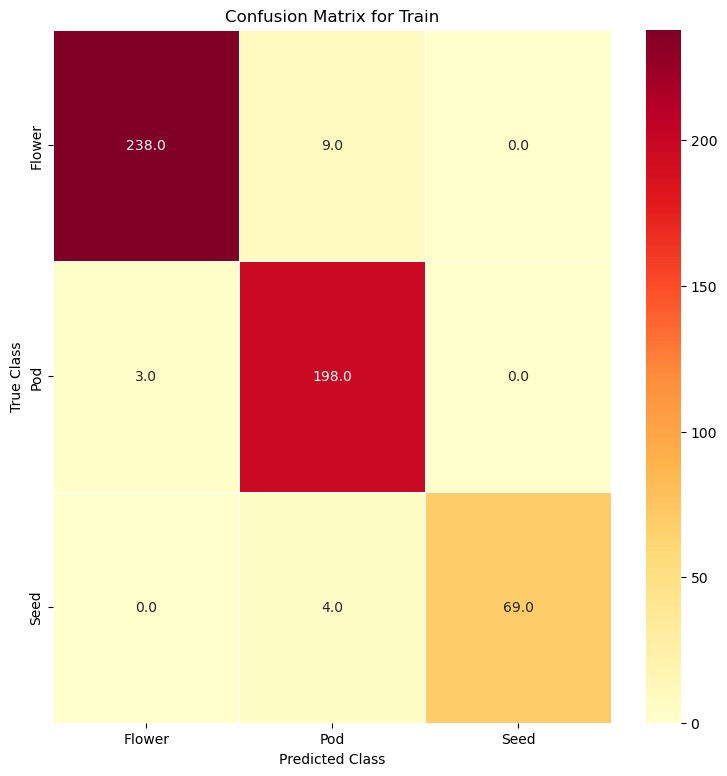

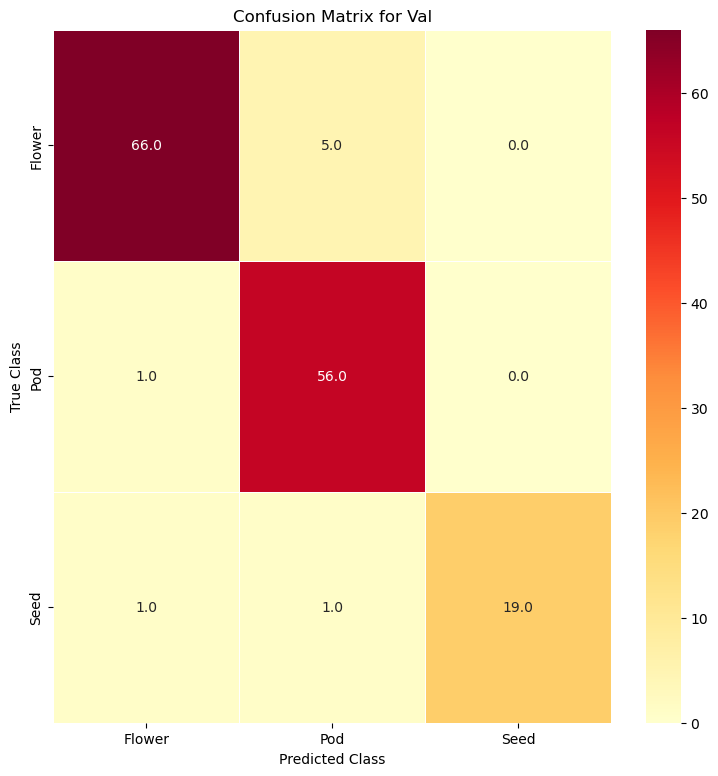

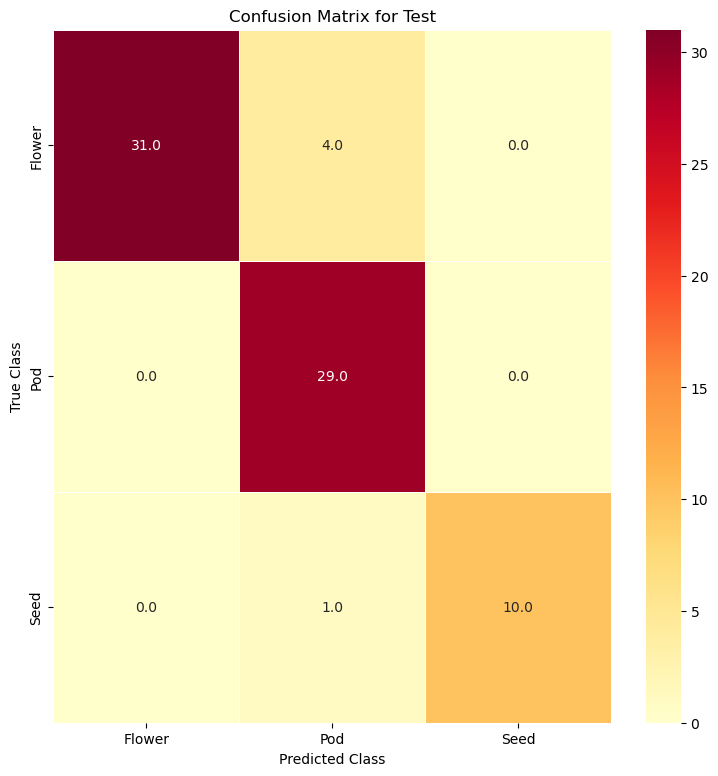

In [46]:
heat_map_train, heat_map_val, heat_map_test = heat_map_visualization(model)

In [32]:
def convert_to_np(cuda_list):
    temp_c = [l.cpu().numpy() for l in cuda_list]
    return np.array(temp_c)

In [33]:

def plot_acc_loss(train_acc, train_loss, val_acc, val_loss, test_acc, test_loss, average_epoch_time, total_time):
    fig, axs = plt.subplots(2)

    # Subplot for accuracy
    axs[0].plot(np.arange(0, len(train_acc), 1), convert_to_np(train_acc))
    axs[0].plot(np.arange(0, len(val_acc), 1), convert_to_np(val_acc))
    axs[0].plot(np.arange(0, len(test_acc), 1), convert_to_np(test_acc))
    axs[0].legend(["Train Accuracy", "Validation Accuracy","Test Accuracy"])
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].text(0.5, 0.5, f'Total Time: {total_time:.2f}s\nAverage Epoch Time: {average_epoch_time:.2f}s', horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes)
    
    # Subplot for loss
    axs[1].plot(np.arange(0, len(train_loss), 1), train_loss)
    axs[1].plot(np.arange(0, len(val_loss), 1), val_loss)
    axs[1].plot(np.arange(0, len(test_loss), 1), test_loss)
    axs[1].legend(["Train Loss", "Validation Loss", "Test Loss"])
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")

    # Display the plot
    plt.tight_layout()
    plt.show()

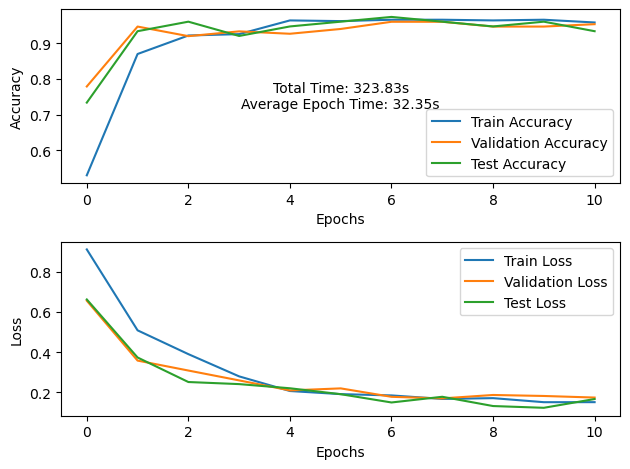

In [47]:
plot_acc_loss(train_acc, train_loss, val_acc, val_loss, test_acc, test_loss, average_epoch_time, total_time)

In [48]:
import numpy as np

def metrics_from_confusion_matrix(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    # Initialize arrays to store TP, FP, FN, TN
    true_positives = np.zeros(num_classes)
    false_positives = np.zeros(num_classes)
    false_negatives = np.zeros(num_classes)
    true_negatives = np.zeros(num_classes)

    for i in range(num_classes):
        true_positives[i] = confusion_matrix[i, i]
        false_negatives[i] = np.sum(confusion_matrix[i, :]) - true_positives[i]
        false_positives[i] = np.sum(confusion_matrix[:, i]) - true_positives[i]
        true_negatives[i] = np.sum(confusion_matrix) - (true_positives[i] + false_positives[i] + false_negatives[i])

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1 = 2 * (precision * recall) / (precision + recall)

    # Calculate macro and weighted averages
    macro_f1 = np.mean(f1)
    weighted_f1 = np.sum(f1 * np.sum(confusion_matrix, axis=1)) / np.sum(confusion_matrix)

    metrics = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1
    }
    labels = ["Flower", "Pod", "Seed"]
    for i in range(num_classes):
        print(labels[i])
        print("Precision = {}, recall = {}, f1 = {}\n".format(precision[i], recall[i], f1[i]))

    return metrics


In [49]:
def visualize_metrics(metrics):
    labels = ["Flower", "Pod", "Seed"]
    classes = [labels[i] for i in range(len(metrics['precision']))]
    precision = metrics['precision']
    recall = metrics['recall']
    f1 = metrics['f1']

    barWidth = 0.25
    r1 = np.arange(len(precision))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    # Colors based on ColorBrewer
    colors = ['#66c2a5', '#fc8d62', '#8da0cb']

    plt.figure(figsize=(10,7))

    plt.bar(r1, precision, color=colors[0], width=barWidth, edgecolor='grey', label='Precision')
    plt.bar(r2, recall, color=colors[1], width=barWidth, edgecolor='grey', label='Recall')
    plt.bar(r3, f1, color=colors[2], width=barWidth, edgecolor='grey', label='F1-score')

    plt.xlabel('Classes', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(precision))], classes)
    plt.ylabel('Score')
    plt.title('Precision, Recall and F1-score for each class')
    plt.legend()

    plt.tight_layout()
    plt.show()


The metrics for train process:

Flower
Precision = 0.9875518672199171, recall = 0.9635627530364372, f1 = 0.9754098360655739

Pod
Precision = 0.9383886255924171, recall = 0.9850746268656716, f1 = 0.9611650485436893

Seed
Precision = 1.0, recall = 0.9452054794520548, f1 = 0.971830985915493



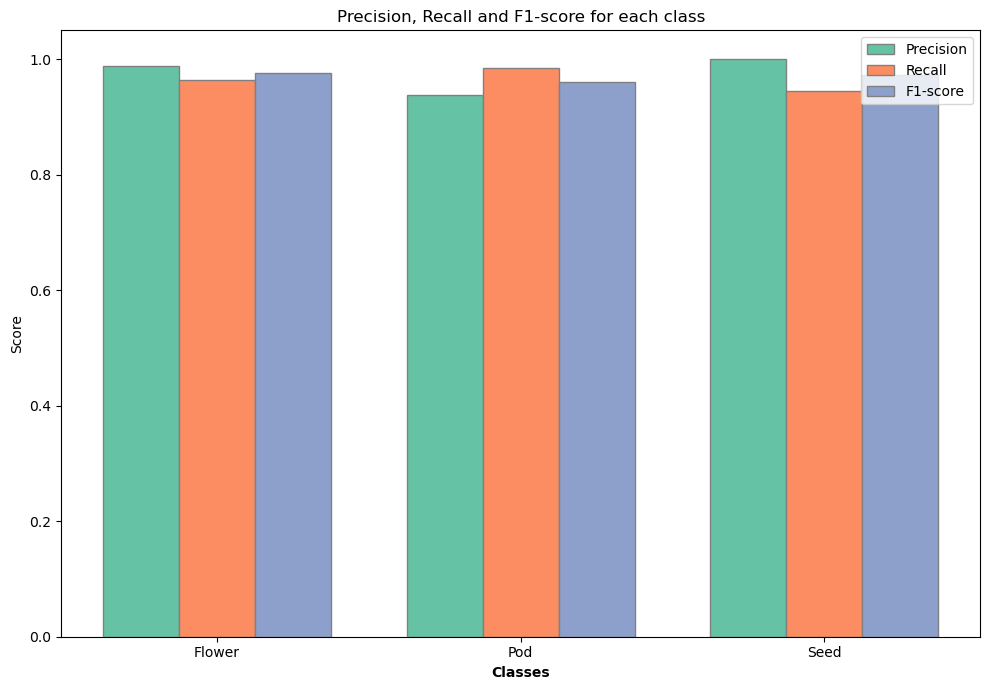

The metrics for test process:

Flower
Precision = 1.0, recall = 0.8857142857142857, f1 = 0.9393939393939393

Pod
Precision = 0.8529411764705882, recall = 1.0, f1 = 0.9206349206349206

Seed
Precision = 1.0, recall = 0.9090909090909091, f1 = 0.9523809523809523



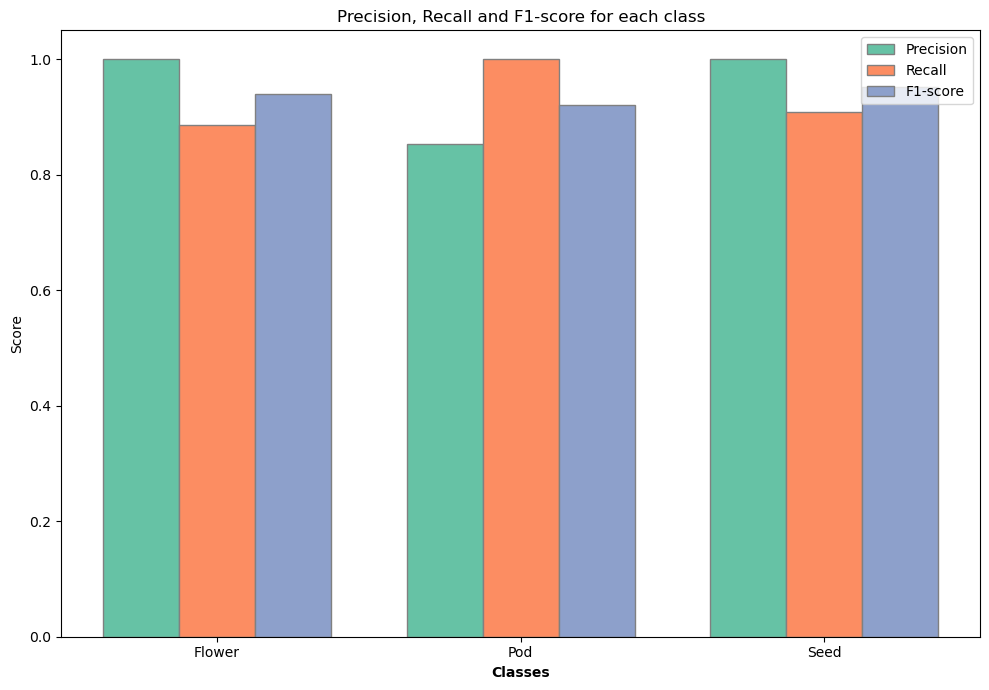

In [50]:
print("The metrics for train process:\n")
train_metrics = metrics_from_confusion_matrix(heat_map_train)
visualize_metrics(train_metrics)
print("The metrics for test process:\n")
test_metrics = metrics_from_confusion_matrix(heat_map_test)
visualize_metrics(test_metrics)

In [51]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curve(all_probs, all_labels, num_classes=3):
    # Convert labels to one-hot encoding
    labels = ["Flower", "Pod", "Seed"]
    one_hot_labels = np.eye(num_classes)[all_labels]

    # Plot linewidth.
    lw = 2

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(one_hot_labels[:, i], np.array(all_probs)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of {0} (area = {1:0.2f})'
                 ''.format(labels[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 0.1])
    plt.ylim([0.0, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Extension of Receiver Operating Characteristic to Multi-Class')
    plt.legend(loc="lower right")
    plt.show()

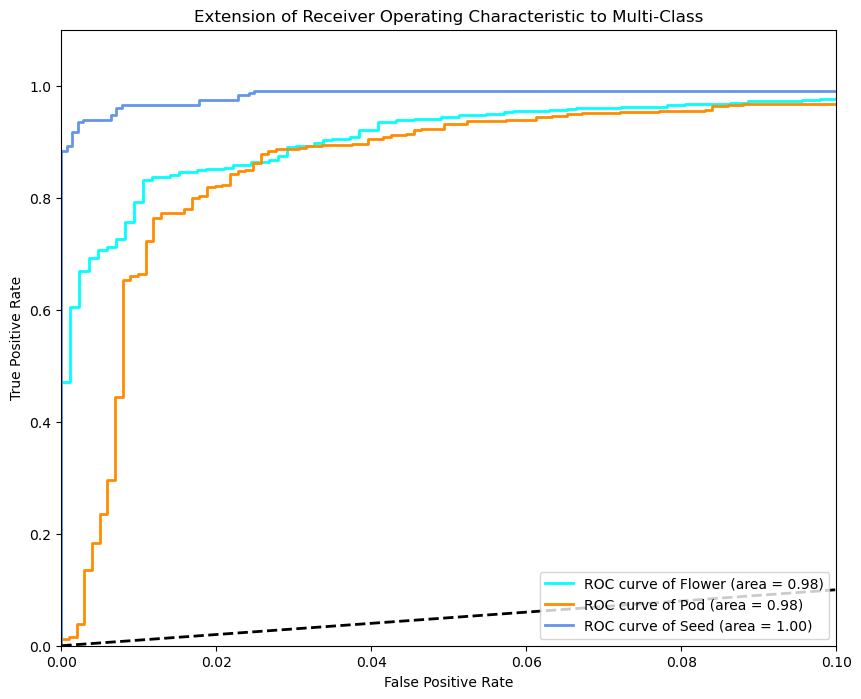

In [52]:
plot_roc_curve(all_probs, all_labels)